In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [43]:
# Helper function to display images
def display_image(img, title="Image", cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('on')
    plt.show()

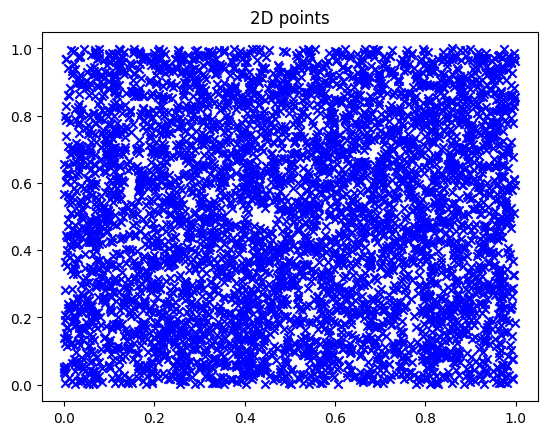

In [44]:
pt = np.random.rand(2,5000)
plt.scatter(pt[0, :], pt[1, :], c='b', marker='x')
plt.title("2D points")
plt.show()

In [45]:
# adding a third dimension
pt = np.vstack((pt, np.zeros(pt.shape[1])))

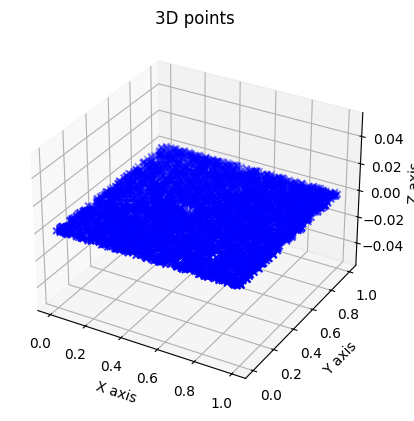

In [46]:
def plot_3d_scatter(pt, color='b'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pt[0, :], pt[1, :], pt[2, :], c=color, marker='x')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.title("3D points")
    plt.show()
plot_3d_scatter(pt)


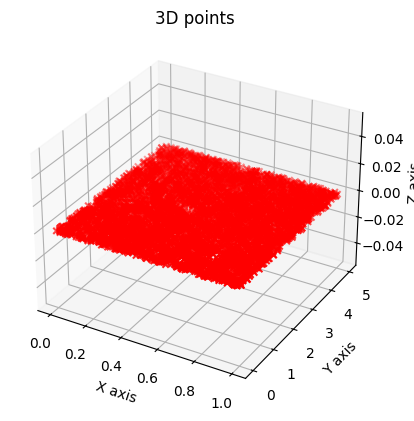

In [47]:
# multiply y axis by 5
pt_copy = pt.copy()
pt_copy[1, :] = pt_copy[1, :] * 5
plot_3d_scatter(pt_copy, color='r')

In [48]:
def eigen_build(observations):
    # Number of observations (n) and dimensionality (d)
    n = observations.shape[1]
    d = observations.shape[0]
    
    # Compute the mean of the observations
    org = np.mean(observations, axis=1)
    
    # Translate the observations by subtracting the mean
    obs_translated = observations - org[:, np.newaxis]
    
    # Compute the covariance matrix
    C = (1 / n) * np.dot(obs_translated, obs_translated.T)
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(C)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Create the eigenmodel structure
    E = {
        'org': org,
        'vct': eigenvectors,
        'val': eigenvalues,
        'N': n
    }
    
    return E

In [66]:
eigen_model = eigen_build(pt_copy)
print("org shape:", eigen_model['org'].shape)
print("vct shape:", eigen_model['vct'].shape)
print("val shape:", eigen_model['val'].shape)
print("N:", eigen_model['N'])
print("d:", eigen_model['vct'].shape[0])

org shape: (3,)
vct shape: (3, 3)
val shape: (3,)
N: 5000
d: 3


In [69]:
print(eigen_model['org'])
print(eigen_model['val'])
print(eigen_model['vct'])
vals = eigen_model['val']
variance = vals[0] / vals[1]
print(variance)

[0.50263042 2.50069899 0.        ]
[2.10047394 0.08243946 0.        ]
[[-0.00829329 -0.99996561  0.        ]
 [-0.99996561  0.00829329  0.        ]
 [ 0.          0.          1.        ]]
25.478988359974974


# Manual PCA Calculation

In [83]:
org = np.mean(pt_copy, axis=1).reshape(-1, 1)
ptsub = pt_copy - org
C = np.cov(ptsub)
val, vct = np.linalg.eig(C)

In [84]:
print("Mean:\n", org)
print("Eigenvalues:\n", val)
print("Eigenvectors:\n", vct)

Mean:
 [[0.50263042]
 [2.50069899]
 [0.        ]]
Eigenvalues:
 [0.08245595 2.10089411 0.        ]
Eigenvectors:
 [[-0.99996561 -0.00829329  0.        ]
 [ 0.00829329 -0.99996561  0.        ]
 [ 0.          0.          1.        ]]


In [132]:

target = cv2.imread("cvprlab_python/testimages/target_yellow.bmp")
target_normalized = target.astype(np.float64)/255.0
target_obs = np.vstack([target_normalized[:, :, i].flatten() for i in range(3)])
target_obs.shape

(3, 1457)

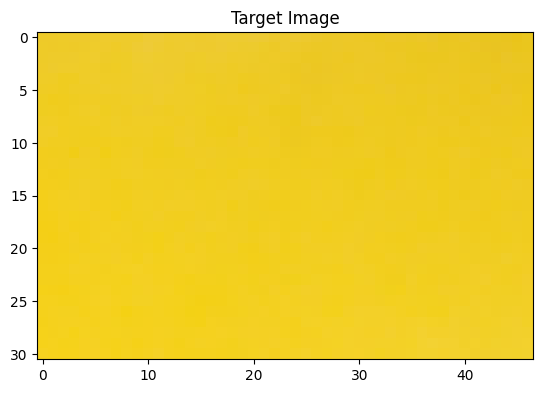

In [134]:
target_rgb = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
display_image(target_rgb, title="Target Image")

In [98]:
target_e = eigen_build(target_obs)
target_e

{'org': array([0.13098093, 0.80355014, 0.94304171]),
 'vct': array([[ 0.93946439, -0.34016285,  0.04118136],
        [-0.23495361, -0.72700487, -0.64518271],
        [-0.24940624, -0.59645047,  0.76291767]]),
 'val': array([4.12985224e-04, 2.19100448e-04, 4.65833221e-06]),
 'N': 1457}

In [103]:
def eigen_mahalanobis(obs, E):
    # Translate observations by subtracting the mean
    obs_translated = obs - E['org'][:, np.newaxis]
    
    # Project the translated observations onto the eigenvectors
    proj = np.dot(E['vct'].T, obs_translated)
    
    # Compute the squared distances
    dstsq = proj ** 2
    
    # Check for eigenvalues of 0 and replace them with 1
    E['val'][E['val'] == 0] = 1
    
    # Compute the Mahalanobis distance
    dst = dstsq / E['val'][:, np.newaxis]
    
    d = np.sum(dst, axis=0)
    
    d = np.sqrt(d)
    
    return d


In [107]:
test = cv2.imread("cvprlab_python/testimages/kitchen.bmp").astype(np.float64)/255.0
test_obs = np.vstack([test[:, :, i].flatten() for i in range(3)])
mdist = eigen_mahalanobis(test_obs, target_e)
mdist.shape

(76800,)

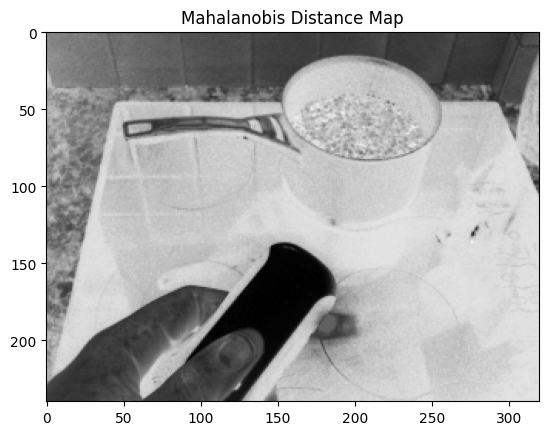

In [112]:
result = mdist.reshape(test.shape[:2])
nresult = result/np.max(result)
display_image(nresult, "Mahalanobis Distance Map", cmap='gray')

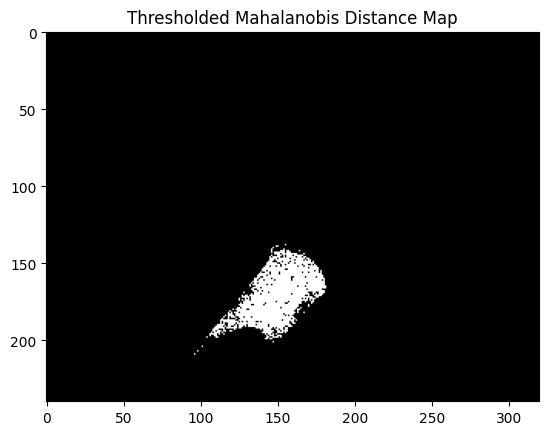

In [117]:
display_image(result < 3, "Thresholded Mahalanobis Distance Map", cmap='gray')